In [1]:
# Install all required libraries with specific versions
!pip install -q\
    asttokens==3.0.0 \
    comm==0.2.2 \
    contourpy==1.3.2 \
    cycler==0.12.1 \
    debugpy==1.8.14 \
    decorator==5.2.1 \
    exceptiongroup==1.2.2 \
    executing==2.2.0 \
    fonttools==4.57.0 \
    ipykernel==6.29.5 \
    ipython==8.36.0 \
    jedi==0.19.2 \
    jupyter_client==8.6.3 \
    jupyter_core==5.7.2 \
    kiwisolver==1.4.8 \
    matplotlib==3.10.3 \
    matplotlib-inline==0.1.7 \
    nest-asyncio==1.6.0 \
    numpy==2.2.5 \
    opencv-python==4.11.0.86 \
    packaging==25.0 \
    parso==0.8.4 \
    pexpect==4.9.0 \
    pillow==11.2.1 \
    platformdirs==4.3.8 \
    prompt_toolkit==3.0.51 \
    psutil==7.0.0 \
    ptyprocess==0.7.0 \
    pure_eval==0.2.3 \
    Pygments==2.19.1 \
    pyparsing==3.2.3 \
    python-dateutil==2.9.0.post0 \
    pyzmq==26.4.0 \
    scipy==1.15.3 \
    six==1.17.0 \
    stack-data==0.6.3 \
    tornado==6.4.2 \
    traitlets==5.14.3 \
    typing_extensions==4.13.2 \
    wcwidth==0.2.13

# Point Set Registration and Image Stitching


In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from typing import Literal

import os
import json

import cv2

# Part A


### SVD


In [3]:
def SVD(A, tol=1e-12):
    """
    Compute the economy-size Singular Value Decomposition of A (m x n)
    Returns U (m x k), S (k x k), Vt (k x n), where k = rank A

    Method:
    - If m >= n, form B = A^T A (n x n), compute eigendecomposition B = V diag(w) V^T.
      Singular values S = sqrt(max(w,0)). Columns of V sorted by descending S.
      Compute U = A V / S.
    - If m < n, form C = A A^T (m x m), eigendecompose C = U diag(w) U^T.
      Singular values S = sqrt(max(w,0)). Compute V = A^T U / S, then Vt = V^T.

    Note: This is the reduced (economic) SVD.
    """
    A = np.asarray(A)
    m, n = A.shape
    k = min(m, n)

    if m >= n:
        # Gram matrix
        B = A.T @ A
        # Use symmetric eigendecomposition
        w, V = np.linalg.eigh(B)
        # Sort in descending order
        idx = np.argsort(w)[::-1]
        w = w[idx]
        V = V[:, idx]
        # Compute singular values
        S = np.sqrt(np.clip(w, 0, None))
        # Build U
        U = A @ V
        for i in range(k):
            if S[i] > tol:
                U[:, i] /= S[i]
            else:
                U[:, i] = 0
        # Truncate
        U = U[:, :k]
        S = S[:k]
        Vt = V[:, :k].T

    else:
        # m < n: work with AA^T
        C = A @ A.T
        w, U = np.linalg.eigh(C)
        idx = np.argsort(w)[::-1]
        w = w[idx]
        U = U[:, idx]
        S = np.sqrt(np.clip(w, 0, None))
        # Build V
        V = A.T @ U
        for i in range(k):
            if S[i] > tol:
                V[:, i] /= S[i]
            else:
                V[:, i] = 0
        U = U[:, :k]
        S = S[:k]
        Vt = V[:, :k].T

    S = np.diag(S)

    reconstructedA = U @ S @ Vt
    assert np.allclose(A, reconstructedA, rtol=tol), "SVD failed"

    return U, S, Vt

### Kabsch Umeyama

    The formula given in the project description is wrong, T should just be of dim d x 1.
    Centering the points is essential which was skipped in the attached files.


In [4]:
# Frobenius norm
def frobenius(A: np.matrix):
    return np.sqrt(np.linalg.trace(A @ A.T))


def kabsch_umeyama(Q: np.matrix, P: np.matrix):
    """
    Find the clothest KU transformation of Q to P.
    shape(P) = shape(Q) = n, d; n is the number of samples and d is the dimension.

    Algorithm from A Purely Algebraic Justification of the Kabsch-Umeyama Algorithm.
    """

    assert Q.shape == P.shape, "There is a mismatch in the shapes of Q and P"

    n, d = Q.shape

    # Calculate the centroids
    mu_Q = np.mean(Q, axis=0)  # 1 x d
    mu_P = np.mean(P, axis=0)  # 1 x d

    # Center the points
    Q = Q - mu_Q  # substract columnwise average from each column
    P = P - mu_P

    # Reshape to d x n
    Q, P = Q.T, P.T

    M = Q @ P.T  # d x d
    V, S, Wt = SVD(M)
    W = Wt.T
    Vt = V.T

    s = [1] * d
    if np.linalg.det(V @ W) <= 0:
        s[d - 1] = -1

    S_hat = np.diag(s)

    U = W @ S_hat @ Vt

    t = mu_P - U @ mu_Q

    """
        Use reconstruct_P function
    """

    return U, t


def reconstruct_P(Q, U, t):
    """
    Assuming, Q.shape = P.shape = (n, d)
    P = (U @ Q.T).T + t.T
    """
    return (U @ Q.T).T + t.ravel()


def rmse(P, reconstructed_P):
    assert P.shape == reconstructed_P.shape, "Shape mismatch"
    return np.sqrt(np.mean(np.square(reconstructed_P - P)))

In [5]:
# Example use in case I forget

P = np.random.random((4, 3))
Q = np.random.random((4, 3))

U, t = kabsch_umeyama(Q, P)
P_reconstructed = reconstruct_P(Q, U, t)

assert rmse(P, P_reconstructed) < 1.0, "The KU approximation failed"

## Apply to the point clouds


In [6]:
# A function to load the data in the np.matrix form
def load_sample(sample: Literal["bottle", "chair", "cup", "plane_example"]):
    # Define the paths
    corr_p = f"dataset1/{sample}/correspondences.txt"
    mat1_p = f"dataset1/{sample}/mat1.txt"
    mat2_p = f"dataset1/{sample}/mat2.txt"

    # Load the data
    mat1 = np.loadtxt(mat1_p)
    mat2 = np.loadtxt(mat2_p)
    corr = np.loadtxt(corr_p).astype(np.int64)

    return mat1, mat2, corr


# A function to draw the 3d point clouds
def draw(mat1, mat2, merged, sample=None):
    fig = plt.figure(figsize=(12, 8))
    axs = [fig.add_subplot(1, 3, i + 1, projection="3d") for i in range(3)]

    axs[0].scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c="red", label="mat1")
    axs[0].set_title("mat1")
    axs[0].legend()

    axs[1].scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c="blue", label="mat2")
    axs[1].set_title("mat2")
    axs[1].legend()

    axs[2].scatter(merged[:, 0], merged[:, 1], merged[:, 2], c="purple", label="merged")
    axs[2].set_title("merged")
    axs[2].legend()

    fig.suptitle("Input mat1, mat2 and merged result")

    fig.legend()
    plt.tight_layout()
    if sample is not None:
        os.makedirs(f"results/{sample}", exist_ok=True)
        plt.savefig(f"results/{sample}/mat1_mat2_merged.png")

    plt.show()


def draw_together(mat1, mat2, sample=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c="red", label="mat1[corr]")
    ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c="blue", label="mat2[corr]")

    ax.set_title(
        "Subclouds from mat1, mat2 with correspondences. (mat1[corr] and mat2[corr])"
    )
    ax.legend()
    plt.tight_layout()
    if sample is not None:
        os.makedirs(f"results/{sample}", exist_ok=True)
        plt.savefig(f"results/{sample}/correspondences.png")
    plt.show()


def pipeline(sample: Literal["bottle", "chair", "cup"]):
    print(f"\n{'='*30}")
    print(f"=== Processing sample: {sample.upper()} ===")
    print(f"{'='*30}\n")

    mat1, mat2, corr = load_sample(sample)

    Q = mat1[corr[:, 0]]
    P = mat2[corr[:, 1]]

    U, t = kabsch_umeyama(P, Q)

    Q_reconstructed = reconstruct_P(mat2, U, t)

    merged = np.vstack([mat1, Q_reconstructed])

    draw_together(Q, P, sample=sample)
    draw(mat1, mat2, merged, sample=sample)
    print("Rotation matrix (R):\n", U)
    print("Translation vector (T):\n", t)

    # Save R and T
    os.makedirs(f"results/{sample}", exist_ok=True)
    np.savetxt(f"results/{sample}/R.txt", U)
    np.savetxt(f"results/{sample}/T.txt", t)

    print("\n\n")



P reconstructed (mat2[corr] reconstructed) using U_orig, t_orig:  0.00010139790168941829 

Rotation Matrix RMSE (Teacher's and Mine):  8.29401893239125e-06
Translation Vector RMSE:  2.4205666795409806e-06




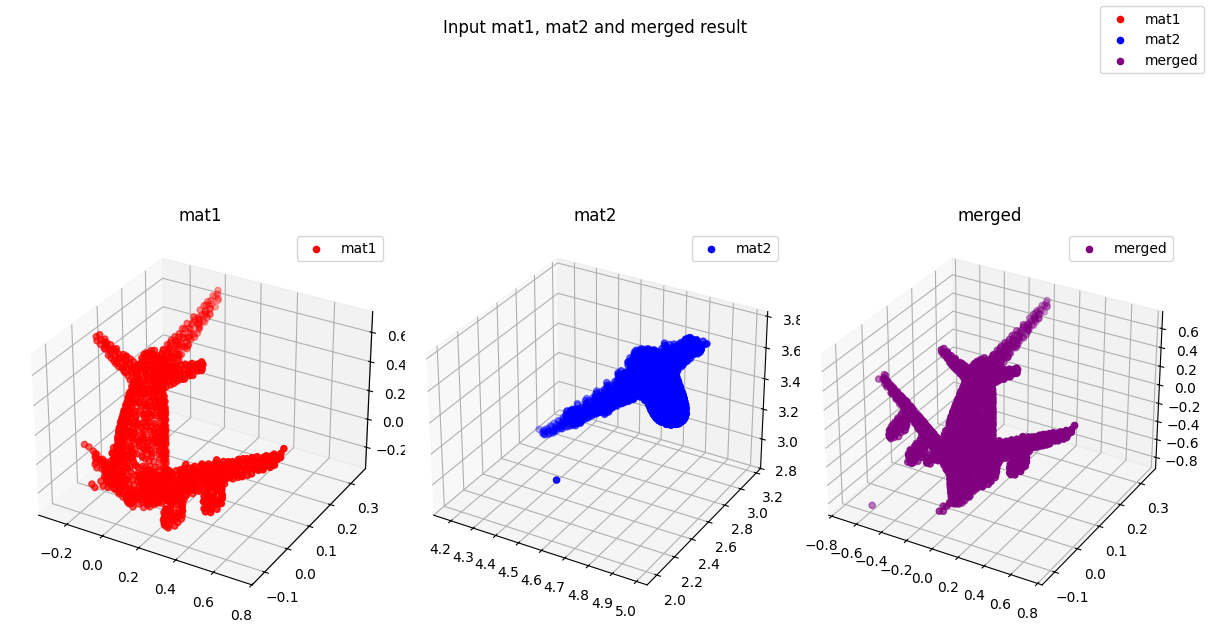

In [7]:
# Test it on plane_example
mat1, mat2, corr = load_sample("plane_example")  # Q_extended, P_extended, crsp

Q = mat1[corr[:, 0]]
P = mat2[corr[:, 1]]

U, t = kabsch_umeyama(Q, P)

# Load the teacher's rotation_matrix and translation vector
U_orig_p, t_orig_p = (
    "dataset1/plane_example/rotation_mat.txt",
    "dataset1/plane_example/translation_vec.txt",
)
U_orig, t_orig = np.loadtxt(U_orig_p), np.loadtxt(t_orig_p)

P_reconstructed = reconstruct_P(Q, U, t)

print("\n")
print(
    "P reconstructed (mat2[corr] reconstructed) using U_orig, t_orig: ",
    rmse(P_reconstructed, P),
    "\n",
)

print("Rotation Matrix RMSE (Teacher's and Mine): ", rmse(U_orig, U))
print("Translation Vector RMSE: ", rmse(t_orig, t))
print("\n")

merged_orig_p = "dataset1/plane_example/merged.txt"
merged_orig = np.loadtxt(merged_orig_p)

draw(mat1, mat2, merged_orig)

In [8]:
# draw_together(Q, P)

    Something is wrong in this picture when i plot it with given merged point cloud, specifically, we calculated U, t to approximate mat2[corr] from mat1[corr]
    but the merged data is the opposite, mat2 is transferred to be close to mat1


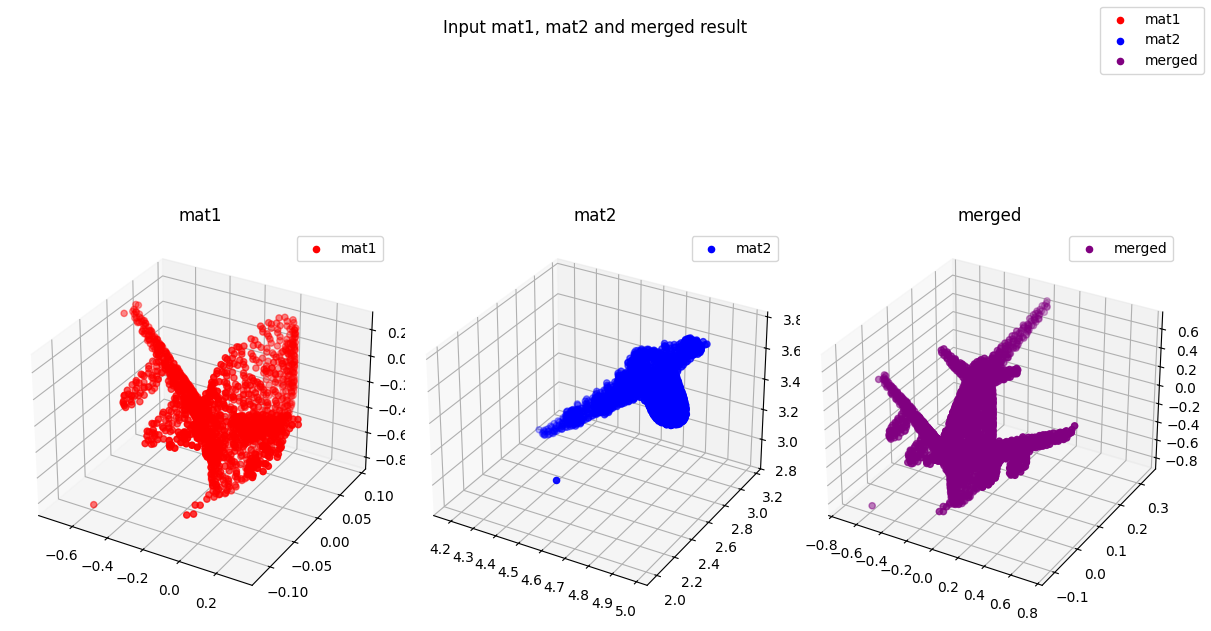

In [9]:
U_crt, t_crt = kabsch_umeyama(P, Q)

Q_reconstructed = reconstruct_P(mat2, U_crt, t_crt)

merged = np.vstack([mat1, Q_reconstructed])

# Here the label is wrong, it is definitely showing reconstructed version of Q
draw(Q_reconstructed, mat2, merged)

## Part A: Results



=== Processing sample: BOTTLE ===



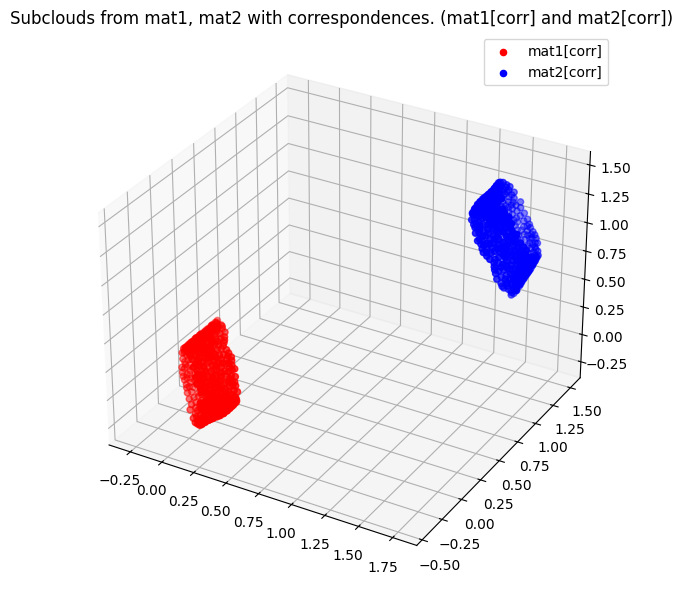

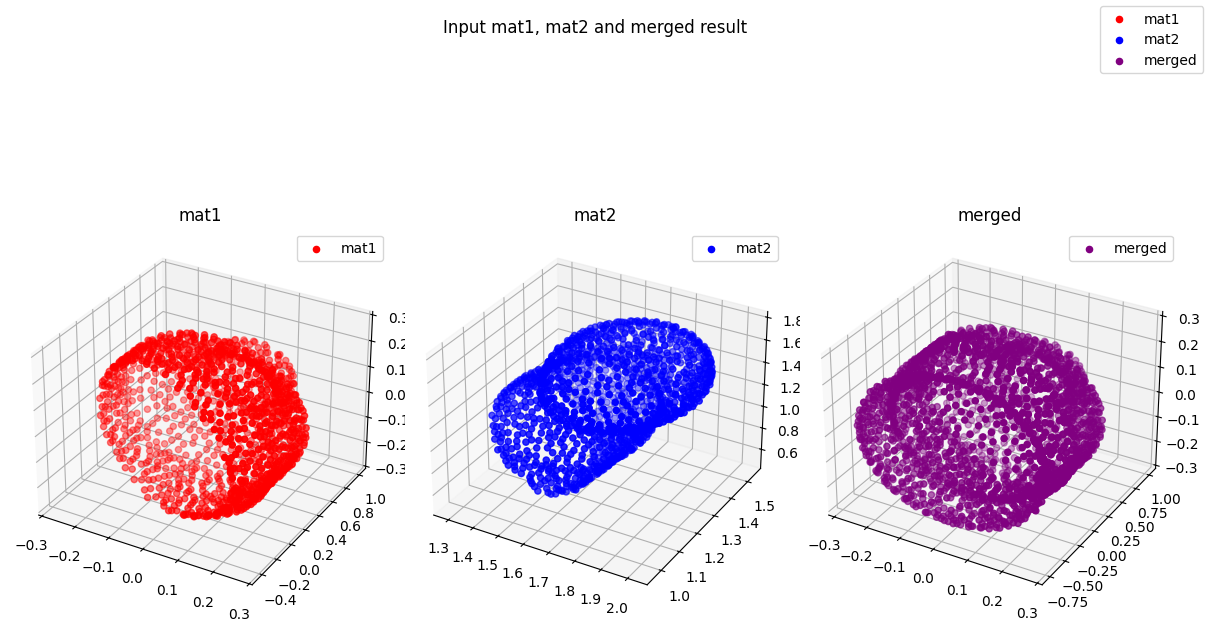

Rotation matrix (R):
 [[-0.7468572  -0.56646154  0.34831832]
 [-0.38868106 -0.05314962 -0.91983811]
 [ 0.5395659  -0.82237245 -0.1804777 ]]
Translation vector (T):
 [1.48934184 1.59086102 0.37030048]




=== Processing sample: CHAIR ===



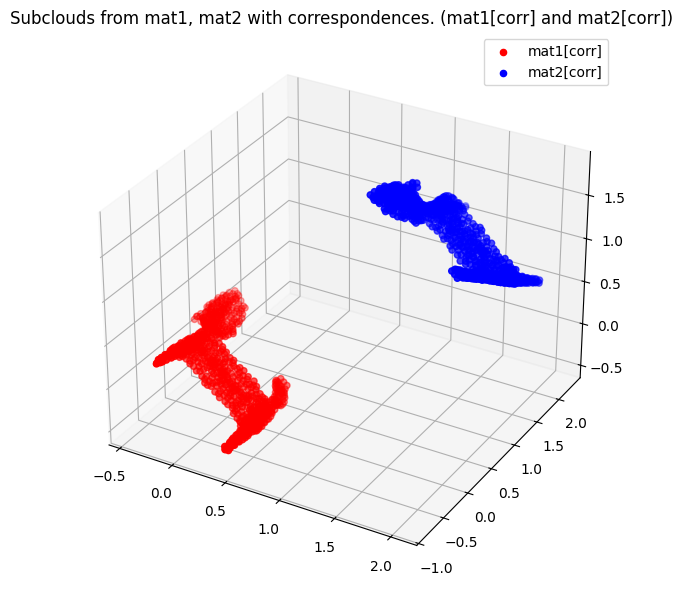

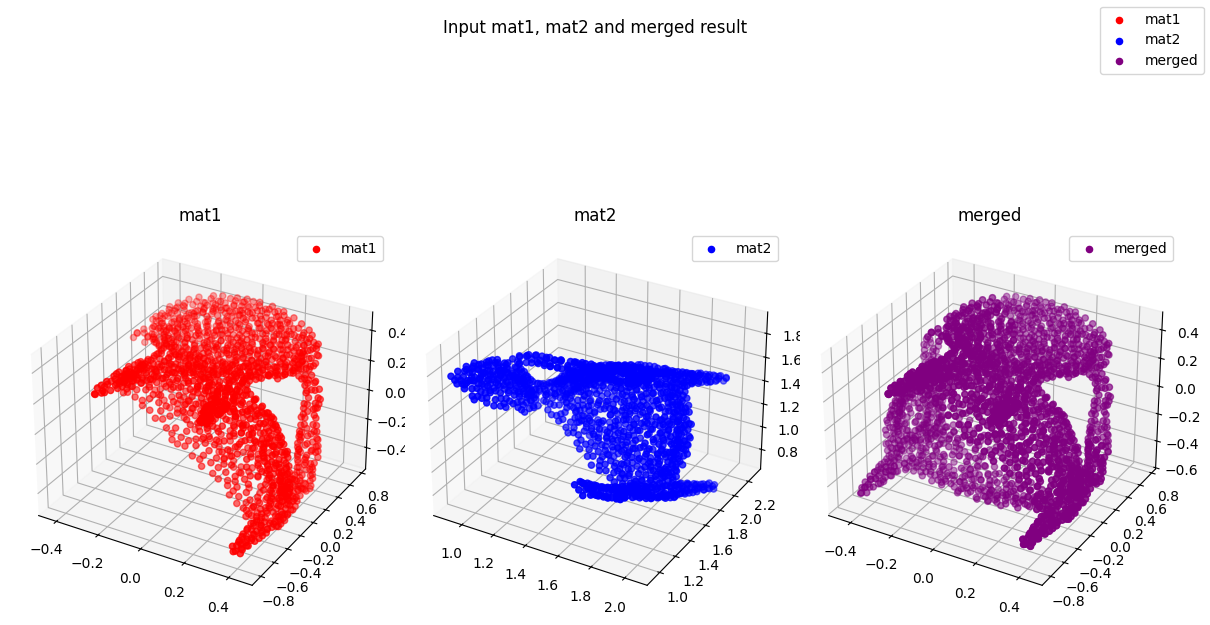

Rotation matrix (R):
 [[ 0.12801764 -0.45352553 -0.88200118]
 [-0.14736851 -0.88814468  0.43529479]
 [-0.98076195  0.07425379 -0.18053357]]
Translation vector (T):
 [1.63378644 0.8939199  1.54240972]




=== Processing sample: CUP ===



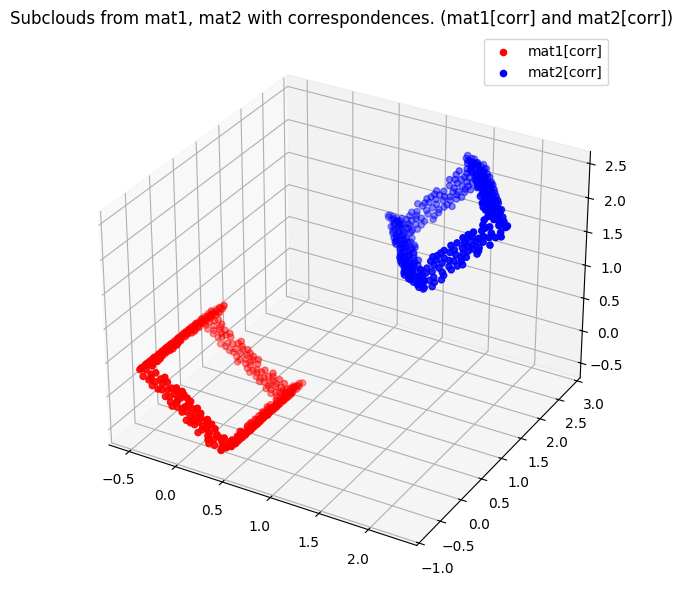

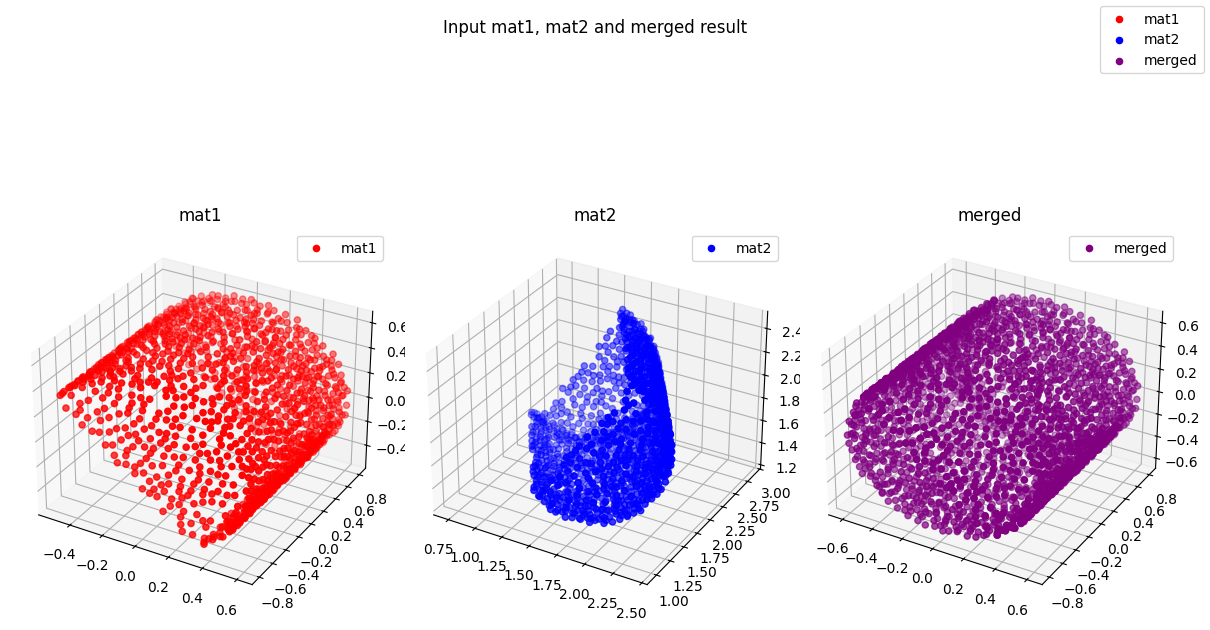

Rotation matrix (R):
 [[-0.10160929 -0.00591879  0.99480677]
 [-0.49427978  0.8681207  -0.04532055]
 [-0.86334411 -0.49631786 -0.09113467]]
Translation vector (T):
 [-1.72172885 -0.81059089  2.41668369]





In [10]:
for sample in ["bottle", "chair", "cup"]:
    pipeline(sample)

# Part B



=== Processing sample: GRID ===



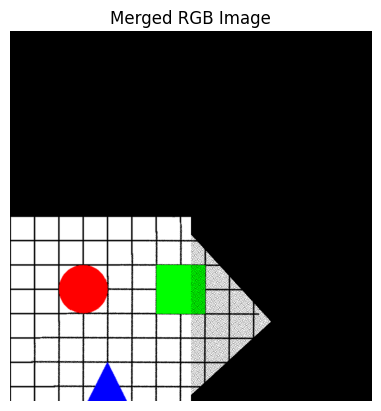

Rotation matrix (R):
 [[ 0.5560261   0.7127846  -0.42751968]
 [ 0.38869472  0.23166031  0.89176786]
 [ 0.73467774 -0.66202085 -0.14824643]]
Translation vector (T):
 [3.36768216e+02 2.38826072e-01]




=== Processing sample: MOUNTAIN ===



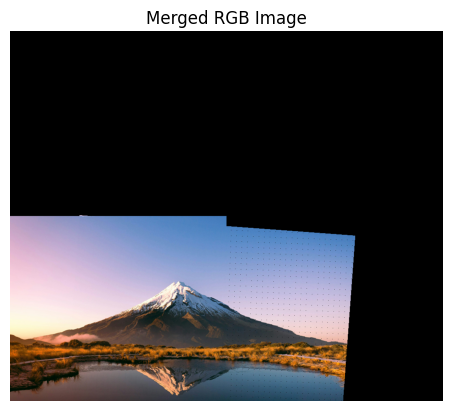

Rotation matrix (R):
 [[ 0.5560261   0.7127846  -0.42751968]
 [ 0.38869472  0.23166031  0.89176786]
 [ 0.73467774 -0.66202085 -0.14824643]]
Translation vector (T):
 [170.65027066  -1.47103453]




=== Processing sample: PIKACHU ===



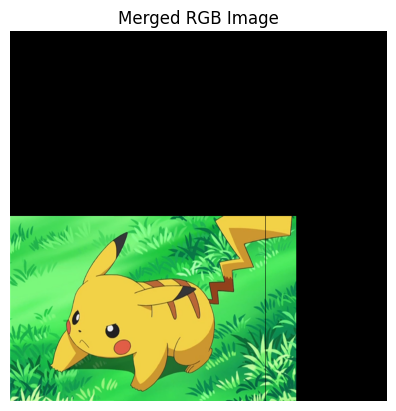

Rotation matrix (R):
 [[ 0.5560261   0.7127846  -0.42751968]
 [ 0.38869472  0.23166031  0.89176786]
 [ 0.73467774 -0.66202085 -0.14824643]]
Translation vector (T):
 [2.08000000e+02 5.68434189e-14]





In [11]:
for sample in ["grid", "mountain", "pikachu"]:
    print(f"\n{'='*30}")
    print(f"=== Processing sample: {sample.upper()} ===")
    print(f"{'='*30}\n")

    img1_p = f"dataset2/{sample}/image1.png"
    img2_p = f"dataset2/{sample}/image2.png"
    corr_p = f"dataset2/{sample}/correspondences.json"
    res_p = f"results/{sample}/merged_result.png"

    # Images are in rgba
    img1 = np.array(Image.open(img1_p).convert("RGB"))
    img2 = np.array(Image.open(img2_p).convert("RGB"))

    # Read correspondences
    with open(corr_p, "r") as f:
        corr = json.load(f)

    corr1 = np.array([row["img1_xy"] for row in corr])
    corr2 = np.array([row["img2_xy"] for row in corr])

    pts1 = corr1.astype(np.float64)
    pts2 = corr2.astype(np.float64)

    # Calculate R, t using correspondences (positions only)
    R, t = kabsch_umeyama(corr2, corr1)

    # Assume the stitched image is double of img1
    h_orig, w_orig = img1.shape[:2]
    h, w, _ = img1.shape
    h, w = 2 * h, 2 * w

    # Initialize an empty merged
    Merged = np.zeros((h, w, 3), dtype=np.uint8)

    # Place img1 at the bottom left of Merged
    Merged[h_orig:, :w_orig] = img1

    # Generate grid of pixel coordinates for img2 (in x,y format)
    h2, w2 = img2.shape[:2]
    jj, ii = np.meshgrid(np.arange(w2), np.arange(h2))
    locs_orig = np.column_stack((jj.ravel(), ii.ravel())).astype(np.float64)

    # Transform coordinates using calculated R and t
    locs_transformed = (R @ locs_orig.T).T + t

    # Convert to merged image coordinates
    merged_rows = (locs_transformed[:, 1] + h_orig).astype(int)  # y' + h_orig
    merged_cols = locs_transformed[:, 0].astype(int)  # x'

    # Flatten img2 colors and filter valid coordinates
    colors = img2.reshape(-1, 3)
    valid_mask = (
        (merged_rows >= 0) & (merged_rows < h) & (merged_cols >= 0) & (merged_cols < w)
    )

    # Place valid pixels in merged image
    Merged[merged_rows[valid_mask], merged_cols[valid_mask]] = colors[valid_mask]

    # Save or display the result
    Image.fromarray(Merged).save(res_p)

    plt.imshow(Merged.astype(np.int64))
    plt.axis("off")  # Optional: hides the axis
    plt.title("Merged RGB Image")  # Optional: add a title
    plt.show()

    print("Rotation matrix (R):\n", U)
    print("Translation vector (T):\n", t)

    # Save R and T
    os.makedirs(f"results/{sample}", exist_ok=True)
    np.savetxt(f"results/{sample}/R.txt", U)
    np.savetxt(f"results/{sample}/T.txt", t)

    print("\n\n")